In [1]:
infrastructures = {
  'education': [
    {
      'ru_name': 'Детские сады',
      'name':'kindergarten',
      'tags': {'amenity':'kindergarten'}
    }, 
    {

      'name':'school',
      'tags':{'amenity':'school'}
    },
    {
      'name':'university',
      'tags':{'amenity':'university'}
    }
  ],
  'healthcare': [
    {
      'name':'polyclinic',
      'tags':{'amenity':'clinic'}
    }, 
    {
      'name':'pharmacy',
      'tags':{'amenity':'pharmacy'}
    }, 
    {
      'name':'hospital',
      'tags':{'amenity':'hospital'}
    }
  ],
  'leisure': [
    # {
    #   'name':'circus',
    #   'tags':{'theatre:genre':'circus'}
    # },
    {
      'name':'zoo',
      'tags':{'tourism':'zoo'}
    },
    {
      'name':'cinema',
      'tags':{'amenity':'cinema'}
    },
    {
      'name':'mall',
      'tags':{'shop':'mall'}
    },
  ],
  'culture': [
    {
      'name':'museum', 
      'tags':{'tourism':'museum'}
    }, 
    {
      'name':'theatre', 
      'tags':{'amenity':'theatre'}
    }
  ],
  'sport': [
    {
      'name':'pitch',
      'tags':{'leisure':'pitch'}
    },
    {
      'name':'swimming_pool',
      'tags':{'leisure':'swimming_pool'}
    }
  ],
  'tourism': [
    {
      'name':'hotel',
      'tags':{'tourism':'hotel'}
    },
    {
      'name':'hostel',
      'tags':{'tourism':'hostel'}
    }
  ],
}

In [2]:
import pandas as pd
import geopandas as gpd

towns = gpd.read_parquet('data/_towns.parquet')
okrugs = gpd.read_parquet('data/_okrugs.parquet')
rayons = gpd.read_parquet('data/_rayons.parquet')
adj_mx = pd.read_pickle('data/_adj_mx.pickle')

In [3]:
from townsnet.models.region import Region

region = Region(
  towns=towns,
  okrugs=okrugs, 
  rayons=rayons, 
  adjacency_matrix=adj_mx
)

In [4]:
for infrastructure, service_types in infrastructures.items():
  for st_dict in service_types:
    service_type_name = st_dict['name']
    gdf = gpd.read_parquet(f'data/_services_{service_type_name}.parquet')
    region.update_capacities(service_type_name, gdf)

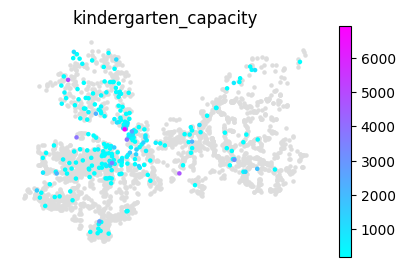

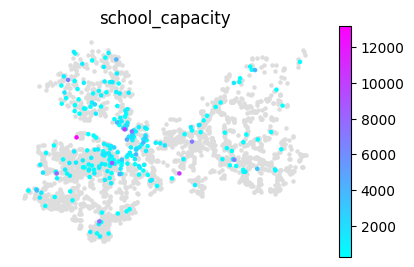

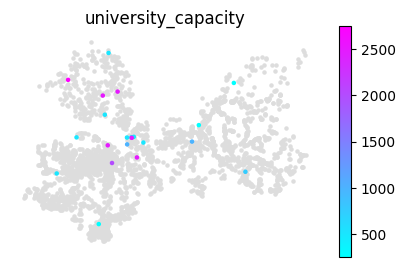

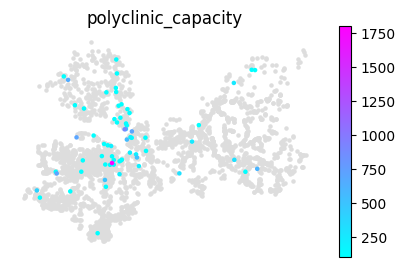

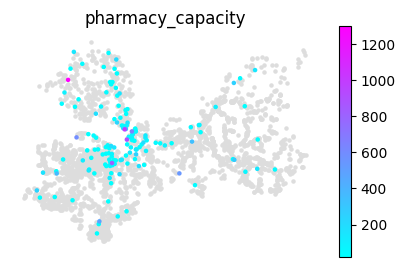

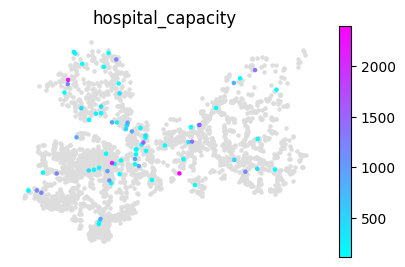

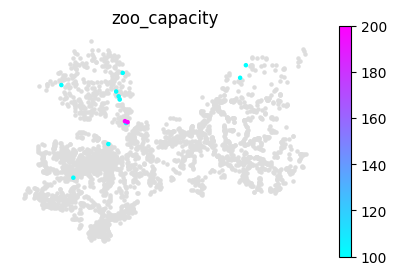

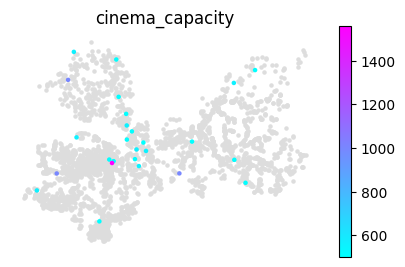

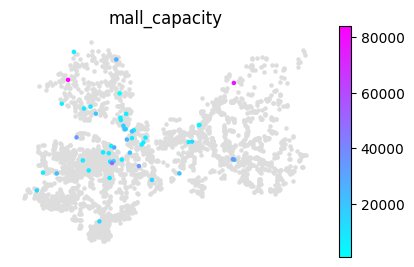

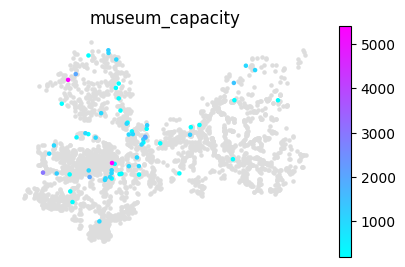

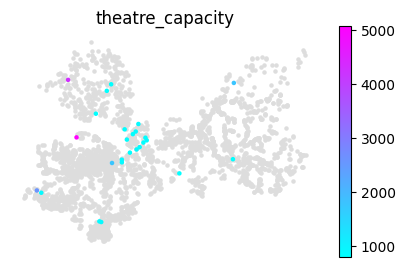

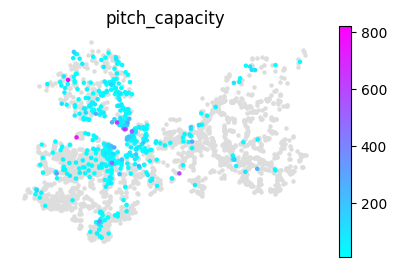

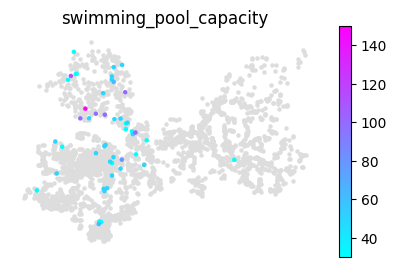

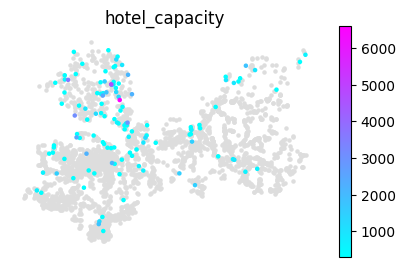

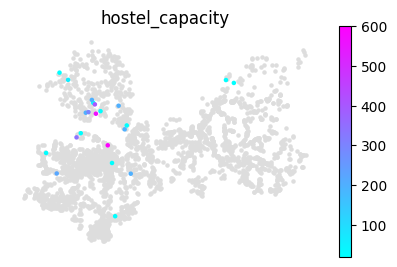

In [5]:
region_gdf = region.to_gdf()
columns = filter(lambda x : x.find('_capacity')>=0,region_gdf.columns)
for column_name in columns:
  ax = region_gdf.loc[region_gdf[column_name]>0].sort_values(by=column_name).plot(
    column=column_name, 
    cmap='cool', 
    legend=True,
    markersize=5,
    figsize=(5,3)
  )
  region_gdf.loc[region_gdf[column_name]==0].plot(color='#ddd', zorder=0, ax=ax, markersize=5)
  ax.set_axis_off()
  ax.set_title(column_name)

In [6]:
from townsnet.method.provision import Provision, ProvisionMethod

prov = Provision(region=region)
prov_dict = {}

for infrastructure, service_types in infrastructures.items():
  for st_dict in service_types:
    service_type_name = st_dict['name']
    prov_dict[service_type_name] = prov.calculate(service_type_name, method=ProvisionMethod.GRAVITATIONAL)
    break
  break 

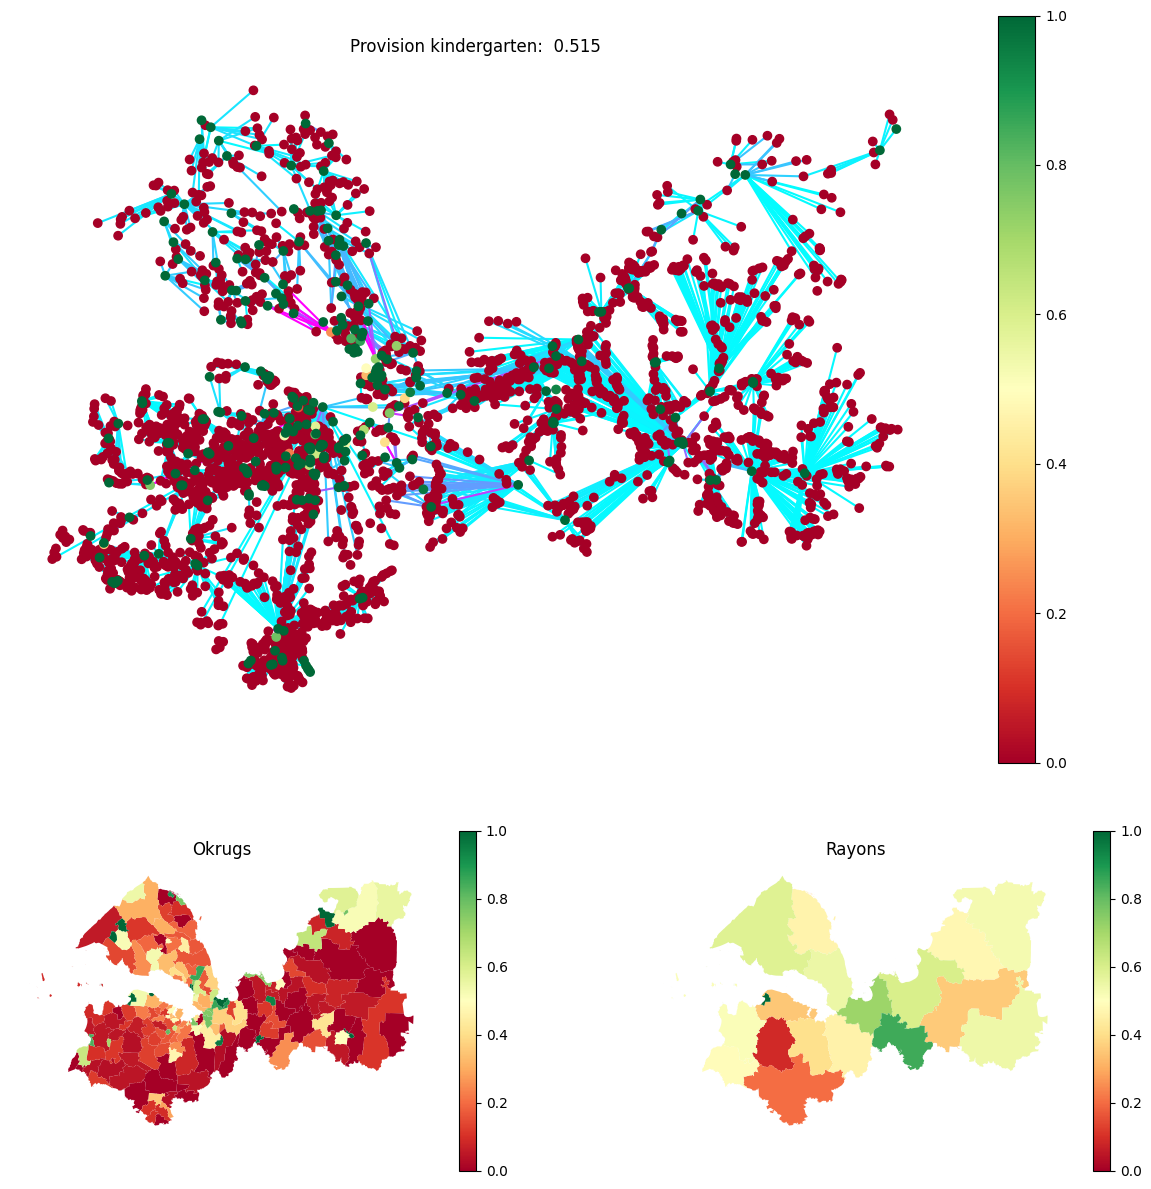

In [7]:
for service_type_name, res_dict in prov_dict.items():
  prov.plot(service_type_name, res_dict[0], res_dict[1]) 

In [31]:
gdf = prov_dict['kindergarten'][0]

0.0

In [9]:
for service_type_name, res_dict in prov_dict.items():
   okrugs_gdf, rayons_gdf = prov.aggregate_units(res_dict[0])
   rayons_gdf.to_crs(4326).to_file(f'res/{service_type_name}_rayons.geojson')
   okrugs_gdf.to_crs(4326).to_file(f'res/{service_type_name}_okrugs.geojson')
   res_dict[0].to_crs(4326).to_file(f'res/{service_type_name}_towns.geojson')
   res_dict[1].to_crs(4326).to_file(f'res/{service_type_name}_ways.geojson')

DriverError: Failed to create GeoJSON datasource: res/kindergarten_rayons.geojson: res/kindergarten_rayons.geojson: No such file or directory